In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [12]:
folder = os.path.join('example_data', 'final_data')
Z = np.load(os.path.join(folder, 'elevation.npy'))
t_Z = np.load(os.path.join(folder, 'elevation_t.npy'))
W = np.load(os.path.join(folder, 'width.npy'))
t_W = np.load(os.path.join(folder, 'width_t.npy'))

In [14]:
Z.shape

(102, 120, 268)

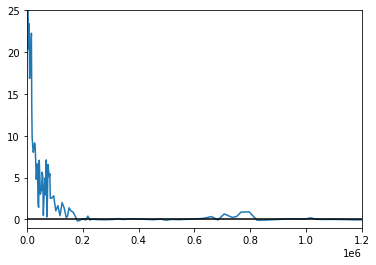

In [30]:
fig, ax = plt.subplots()
vol = np.array([np.nansum(Z[i]) for i in range(Z.shape[0])])
ax.plot((t_Z[:-1]+t_Z[1:])/2, -np.diff(vol)/np.diff(t_Z))

ax.set_xlim(0, 1.2e6)
ax.set_ylim(-1, 25)
ax.plot([0, 1.2e6], [0,0], 'k')